### Testing the period function

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LogNorm
from scipy.signal import find_peaks, correlate
from IPython.display import HTML
from tqdm import tqdm
import pickle
import matplotlib.cm as cm
import visualisation as vis
from delta_hes_model import *

In [61]:
def estimate_period_from_peaks(signal, time=None, height=None, distance=None, prominence=None, ignore_initial_outlier=True):
    """
    Estimate the period of an oscillating signal using peak detection.

    Parameters:
    - signal: 1D numpy array of the signal values
    - time: Optional 1D array of time values (same length as signal). If None, assume uniform time steps.
    - height, distance, prominence: Optional arguments passed to find_peaks
    - ignore_initial_outlier: If True, ignores the first peak if it's a large outlier

    Returns:
    - period: Estimated average period (float)
    - peak_times: Time values of the detected peaks
    """
    # Find peaks
    peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)

    if len(peaks) < 2:
        return None, np.array([])  # Not enough peaks to estimate period

    # Optionally remove initial outlier peak
    peak_vals = signal[peaks]
    # if ignore_initial_outlier and len(peak_vals) > 1.5:
    #     med = np.median(peak_vals[1:])
    #     if peak_vals[0] > 3 * med:
    #         peaks = peaks[1:]
    #         peak_vals = peak_vals[1:]

    # Assume uniform spacing if time is not given
    if time is None:
        time = np.arange(len(signal))

    peak_times = time[peaks]

    if len(peak_times) < 2:
        return None, peak_times  # Still not enough peaks

    # Calculate differences between consecutive peaks
    peak_diffs = np.diff(peak_times)
    period = np.mean(peak_diffs)

    return period, peak_times


In [63]:
with open('results_delay_uniform.pickle', 'rb') as f:
    results_delay_uniform = pickle.load(f)
with open('results_delay_hes_uniform.pickle', 'rb') as f:
    results_delay_hes_uniform = pickle.load(f)

epsilons = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
p_ds = [10, 20, 50, 100, 200]
hill_coeffs = [1, 2, 3, 4, 5]
delays = [0, 1, 2, 5, 10, 20, 30, 40, 50]
gamma_ds = [0.01, 0.02, 0.03, 0.04, 0.05]

num_tsteps = 40000
dt = 0.2

C:\Users\kbmcd\AppData\Local\Temp\ipykernel_19184\1291112951.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


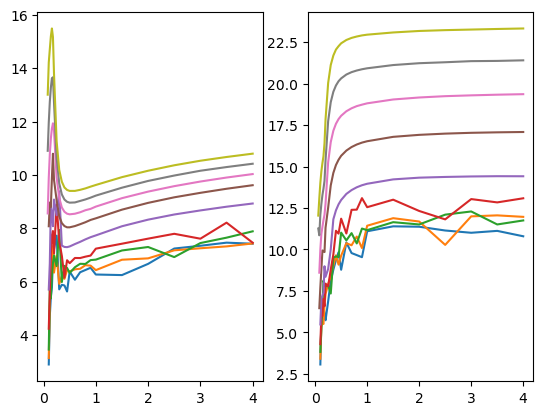

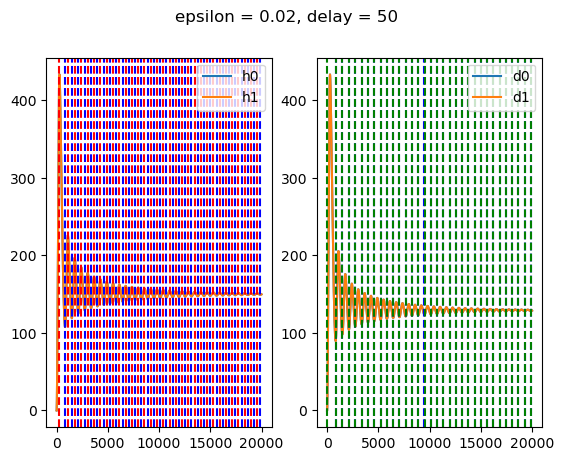

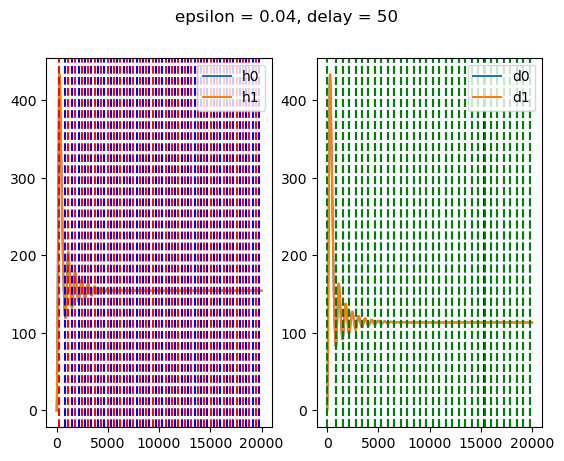

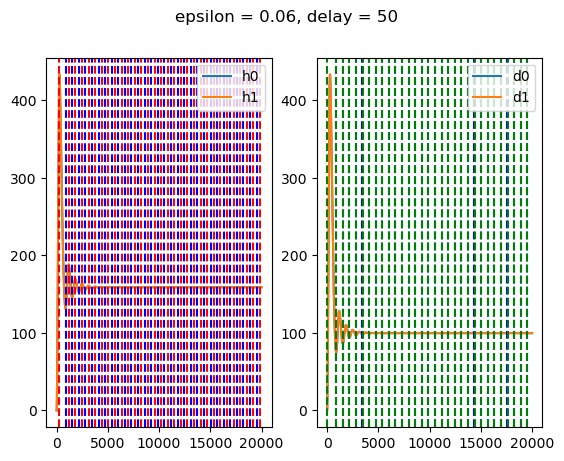

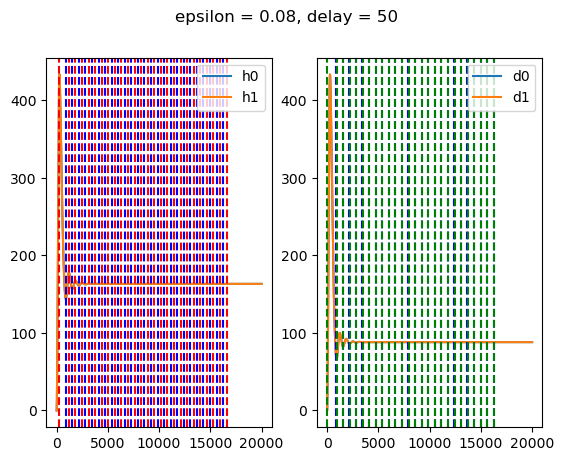

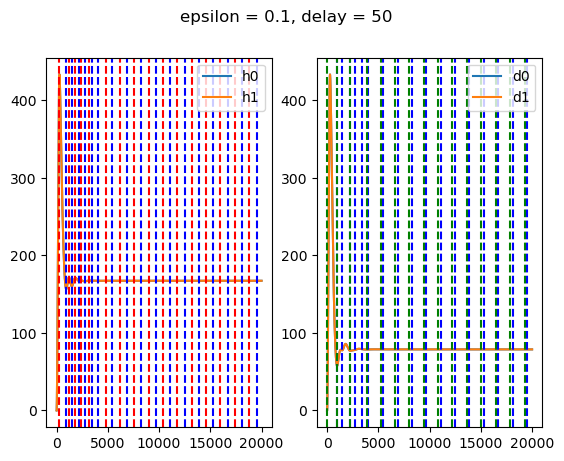

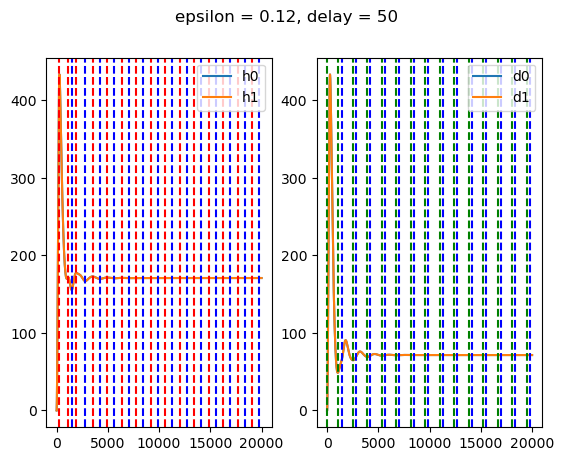

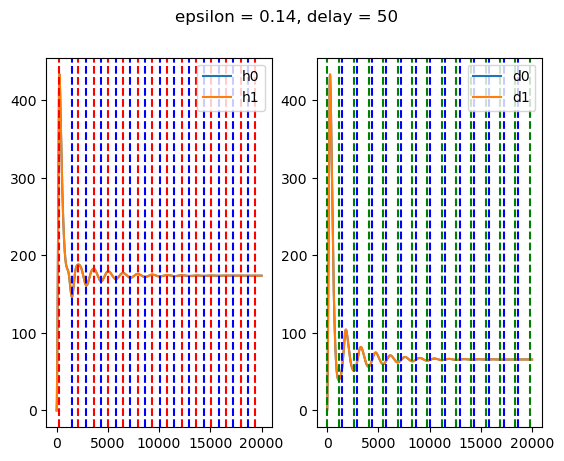

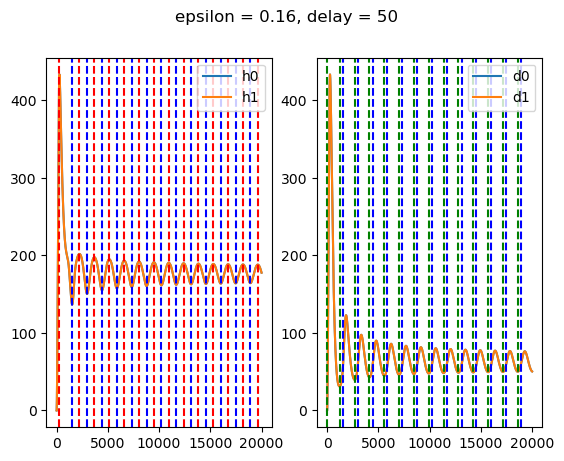

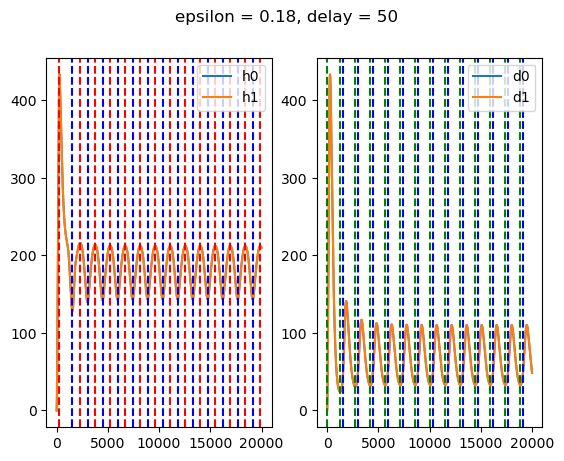

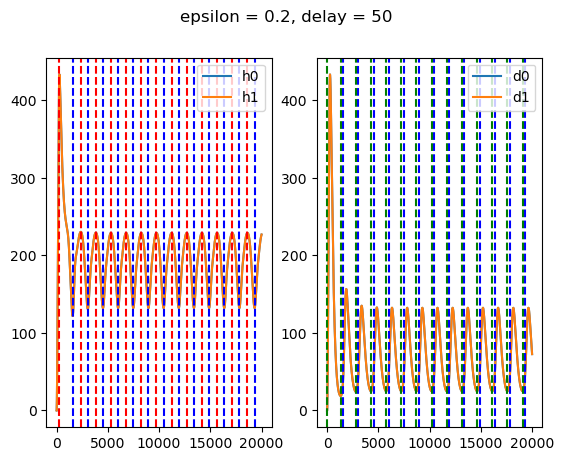

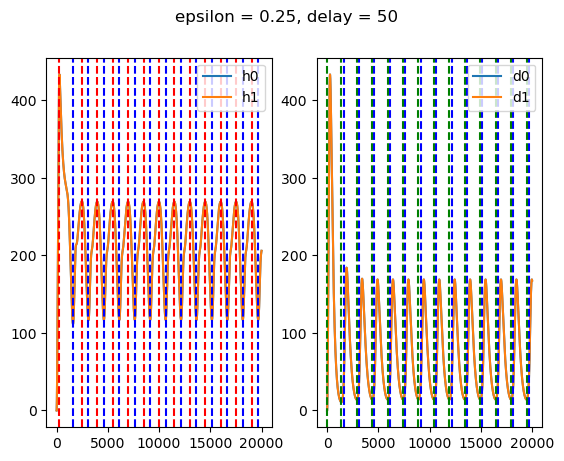

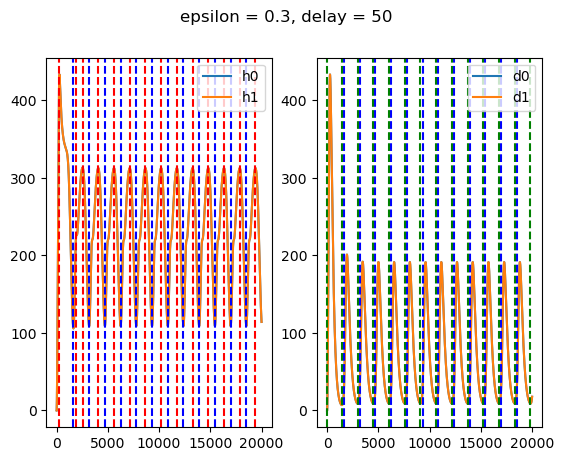

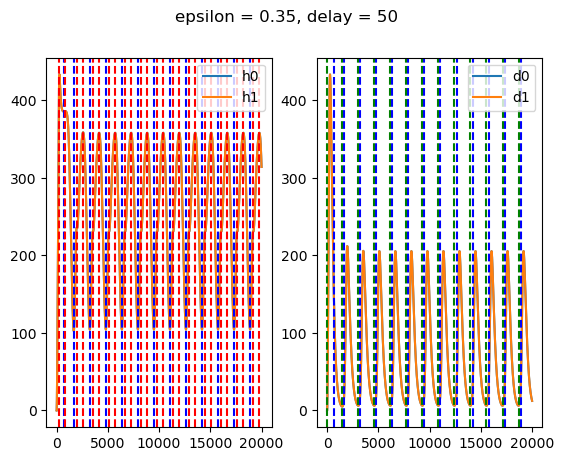

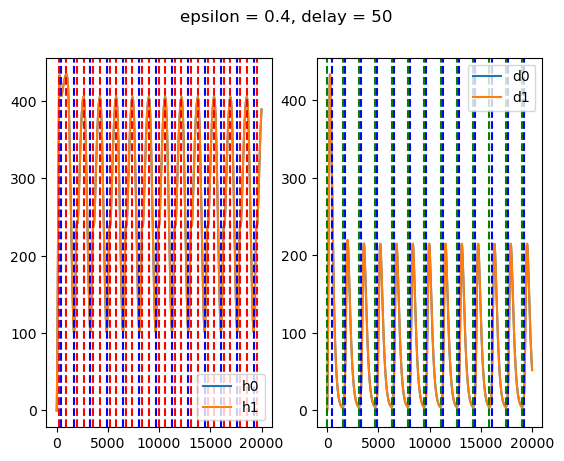

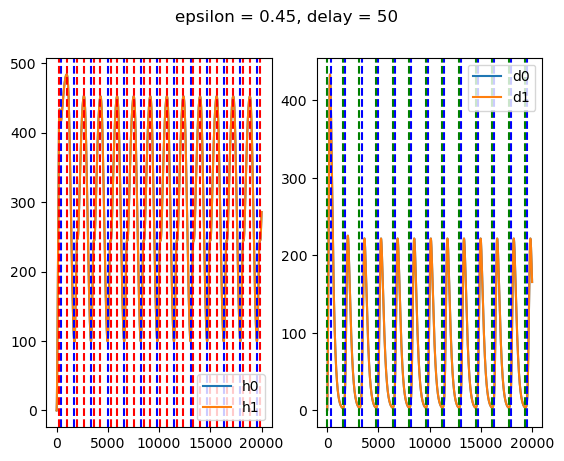

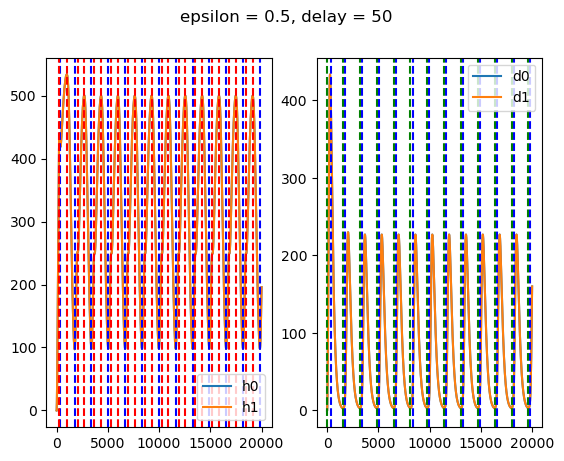

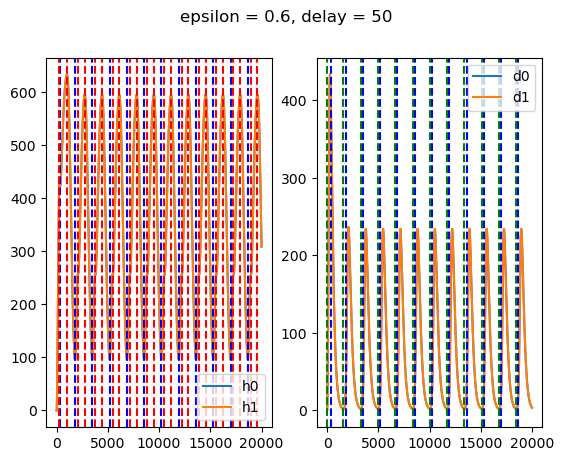

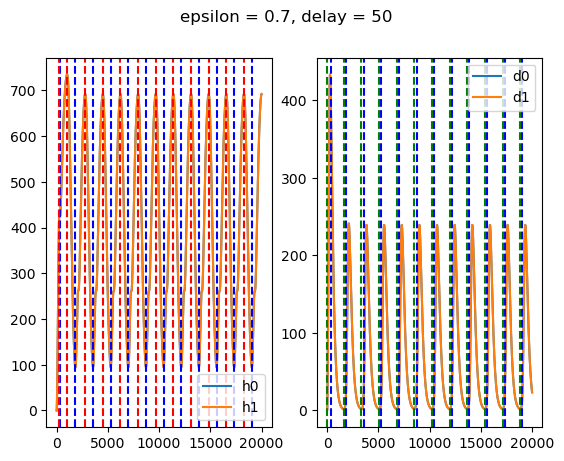

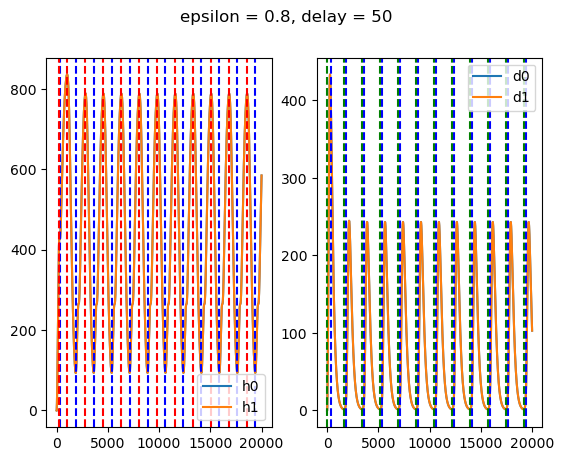

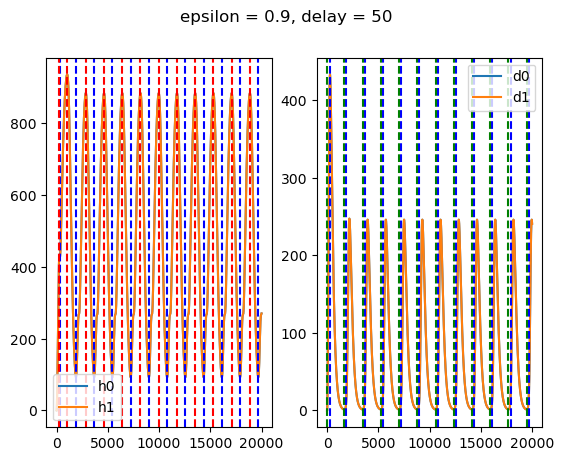

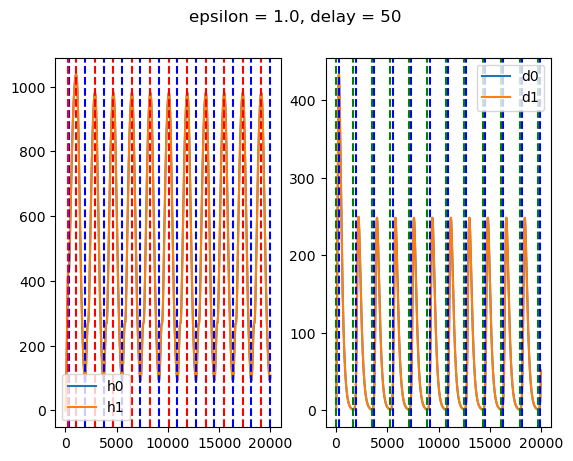

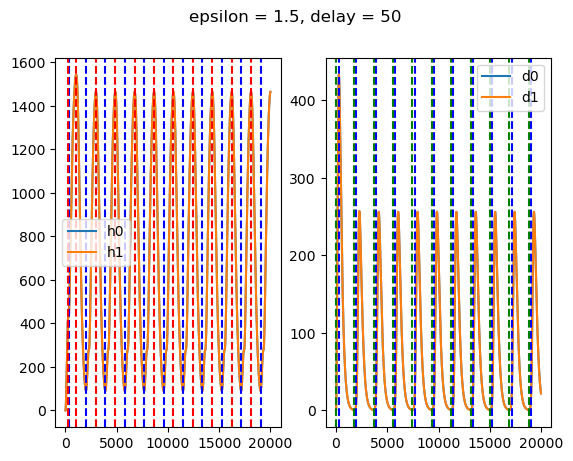

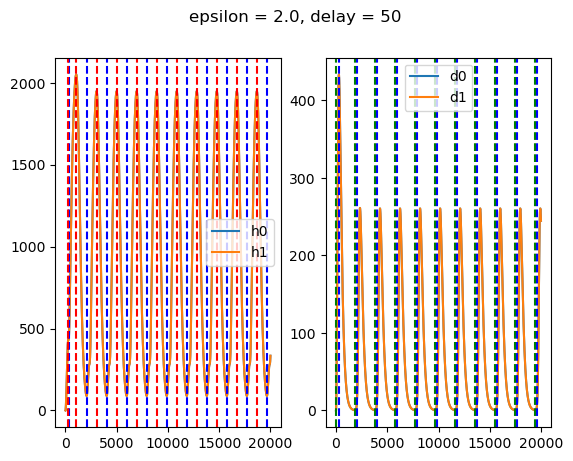

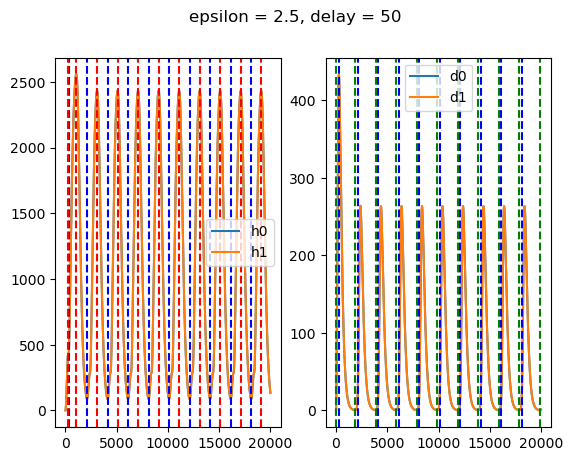

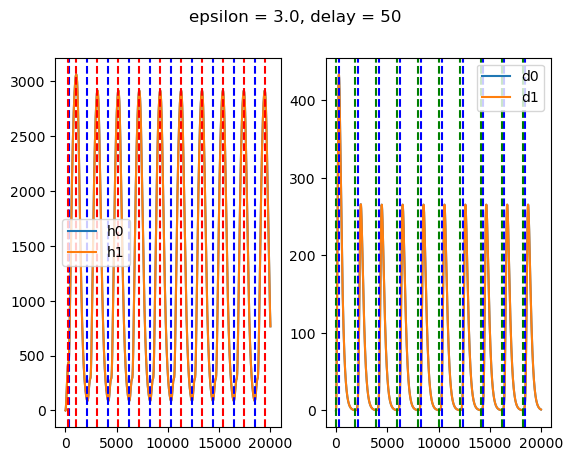

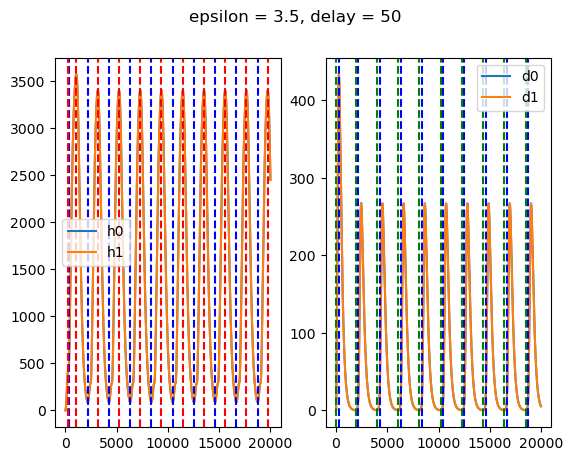

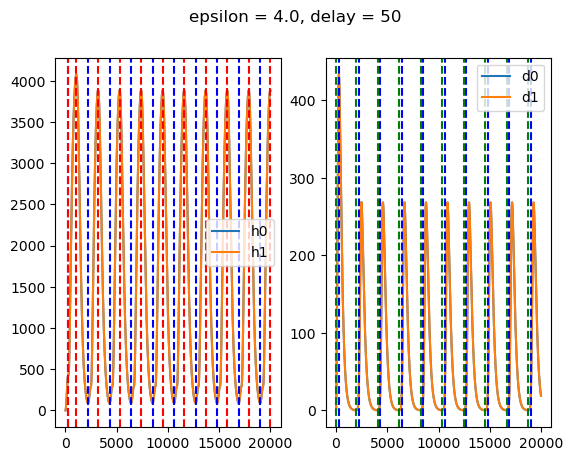

In [ ]:
i = -1
time_settled = 5000
period_peaks = np.zeros((len(delays), len(epsilons)))
period_troughs = np.zeros((len(delays), len(epsilons)))

shift_troughs = np.zeros((len(delays), len(epsilons)))
shift_peaks = np.zeros((len(delays), len(epsilons)))

def find_shift(values_d, values_h):
    values_d = np.array(values_d)
    values_h = np.array(values_h)

    closest = np.zeros(len(values_h))
    distances = np.zeros(len(values_h))

    if len(values_d) == 0 or len(values_h) == 0:
        return np.nan
    for k in range(len(values_h)):
        distance = np.abs(values_h[k] - values_d)
        closest[k] = np.argmin(distance)
        distances[k] = np.min(distance)

    unique, counts = np.unique(closest, return_counts=True)
    duplicates = unique[counts > 1]

    # Get the positions (indexes) of duplicates
    duplicate_positions = {val: np.where(closest == val)[0] for val in duplicates}

    # Set others to NaN (or -1 if you prefer an int flag)
    cleaned_closest = closest.astype(float)  # allow NaN
    for dup_val, positions in duplicate_positions.items():
        # Find the one with the smallest distance
        best_idx = positions[np.argmin(distances[positions])]
        # Set others to NaN
        for idx in positions:
            if idx != best_idx:
                cleaned_closest[idx] = np.nan
                distances[idx] = np.nan

    shift = np.nanmean(distances)*dt

    return shift


for i in range(len(delays)):
    for j in range(len(epsilons)):
        period_peaks[i,j], peaks_h = estimate_period_from_peaks(results_delay_uniform[i,j,time_settled:,0,0], time=np.arange(num_tsteps-time_settled)*dt, distance=500)
        period_troughs[i,j], troughs_h = estimate_period_from_peaks(-results_delay_uniform[i,j,time_settled:,0,0]+np.max(results_delay_uniform), time=np.arange(num_tsteps-time_settled)*dt, distance=500)
        period_peaks[i,j], peaks_d = estimate_period_from_peaks(results_delay_uniform[i,j,time_settled:,1,0], time=np.arange(num_tsteps-time_settled)*dt, distance=500)
        period_troughs[i,j], troughs_d = estimate_period_from_peaks(-results_delay_uniform[i,j,time_settled:,1,0]+np.max(results_delay_uniform), time=np.arange(num_tsteps-time_settled)*dt, distance=500)

        # print(f'for delay {delays[i]} and epsilon {epsilons[j]}:')
        # #calculate shift in troughs between h and d
        # print(f'h_troughs = {troughs_h, len(troughs_h)}, d_troughs = {troughs_d, len(troughs_d)}')

        shift_troughs[i,j] = find_shift(troughs_d, troughs_h)
        shift_peaks[i,j] = find_shift(peaks_d, peaks_h)


plt.figure()

for i in range(len(delays)):
    plt.subplot(1, 2, 1)
    plt.plot(epsilons, shift_troughs[i,:], label=f'delay = {delays[i]}')

    plt.subplot(1, 2, 2)
    plt.plot(epsilons, shift_peaks[i,:], label=f'delay = {delays[i]}')

# plt.figure()
# plt.subplot(1, 2, 1)
# plt.imshow(period_peaks, aspect='auto', interpolation='nearest', cmap='viridis', extent=[epsilons[0], epsilons[-1], delays[-1], delays[0]])
# plt.colorbar(label='Period peaks')
# plt.subplot(1, 2, 2)
# plt.imshow(period_troughs, aspect='auto', interpolation='nearest', cmap='viridis', extent=[epsilons[0], epsilons[-1], delays[-1], delays[0]])
# plt.colorbar(label='Period troughs')


for j in range(len(epsilons)):
    period, peaks = estimate_period_from_peaks(results_delay_hes_uniform[i,j,:,0,0], time=np.arange(num_tsteps)*dt, distance=500)
    period_troughs, troughs = estimate_period_from_peaks(-results_delay_hes_uniform[i,j,:,0,0], time=np.arange(num_tsteps)*dt, distance=500)
    period_d_troughs, troughs_d = estimate_period_from_peaks(-results_delay_hes_uniform[i,j,:,1,0], time=np.arange(num_tsteps)*dt, distance=500)
    period_d, peaks_d = estimate_period_from_peaks(results_delay_hes_uniform[i,j,:,1,0], time=np.arange(num_tsteps)*dt, distance=500)
    peaks = peaks/dt
    peaks_d = peaks_d/dt
    troughs = troughs/dt
    troughs_d = troughs_d/dt

    # if j == 0:
    #     print(troughs)
    #     print(np.diff(troughs))

    plt.figure()
    plt.suptitle(f'epsilon = {epsilons[j]}, delay = {delays[i]}')
    plt.subplot(1, 2, 1)
    plt.plot(results_delay_hes_uniform[i,j,:,0,0], label='h0')
    plt.plot(results_delay_hes_uniform[i,j,:,0,1], label='h1')

    for k in range(len(troughs)):
        plt.axvline(x=troughs[k], color='b', linestyle='--')
    for k in range(len(peaks)):
        plt.axvline(x=peaks[k], color='red', linestyle='--')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(results_delay_hes_uniform[i,j,:,1,0], label='d0')
    plt.plot(results_delay_hes_uniform[i,j,:,1,1], label='d1')
    for k in range(len(troughs)):
        plt.axvline(x=troughs[k], color='blue', linestyle='--')
    # for k in range(len(peaks)):
    #     plt.axvline(x=peaks[k], color='red', linestyle='--')
    for k in range(len(troughs_d)):
        plt.axvline(x=troughs_d[k], color='green', linestyle='--')
    # for k in range(len(peaks_d)):
    #     plt.axvline(x=peaks_d[k], color='lightblue', linestyle='--')
    plt.legend()



# Test it for laterally inhibiting functions

In [20]:
epsilons = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
p_ds = [10, 20, 50, 100, 200]
hill_coeffs = [1, 2, 3, 4, 5]
delays = [0, 1, 2, 5, 10, 20, 30, 40, 50]
gamma_ds = [0.01, 0.02, 0.03, 0.04, 0.05]

with open('results_pd_uni.pickle', 'rb') as f:
    results_pd_uni = pickle.load(f)
with open('results_pd_hes_uni.pickle', 'rb') as f:
    results_pd_hes_uni = pickle.load(f)

with open('results_pd_hes_checkerboard.pickle', 'rb') as f:
    results_pd_hes_check = pickle.load(f)
with open('results_pd_checkerboard.pickle', 'rb') as f:
    results_pd_check = pickle.load(f)

C:\Users\kbmcd\AppData\Local\Temp\ipykernel_19184\3232874079.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


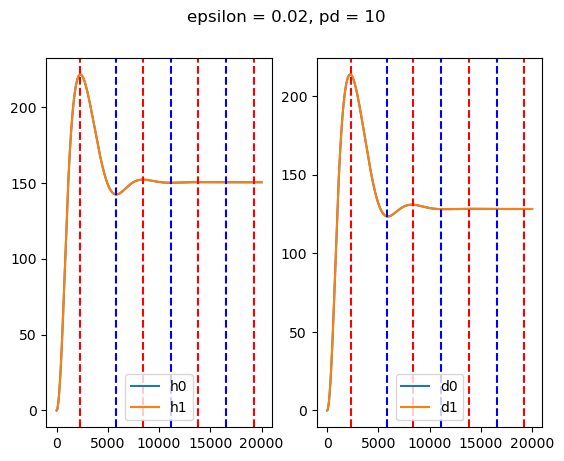

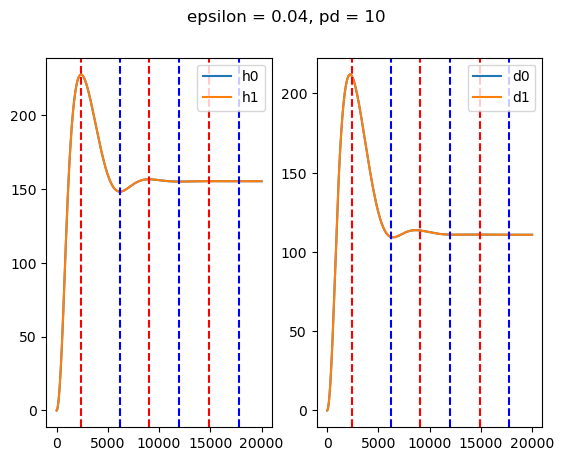

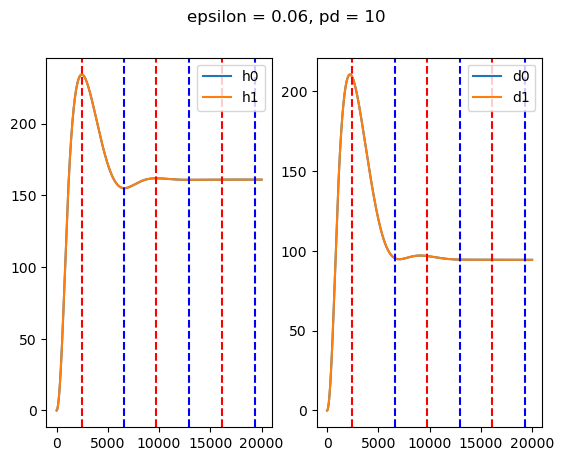

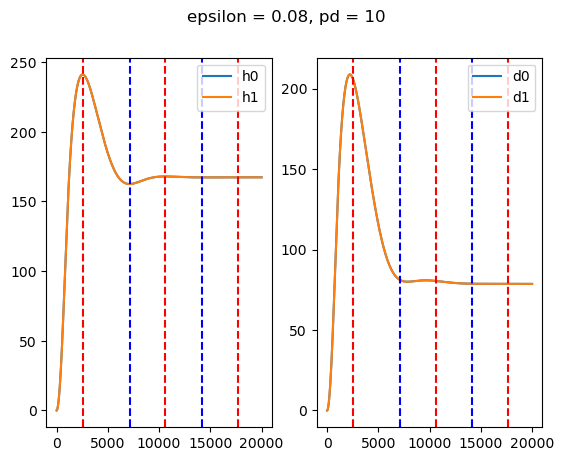

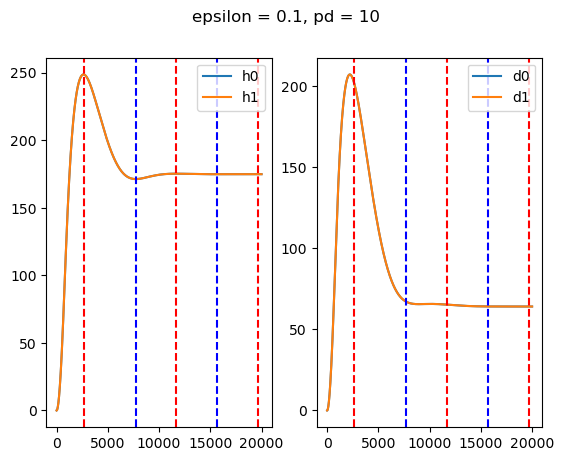

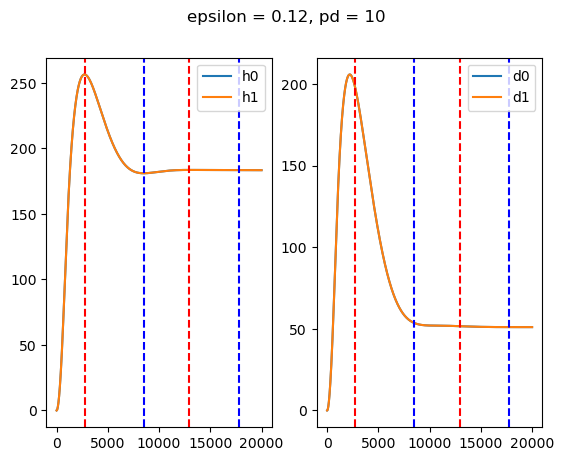

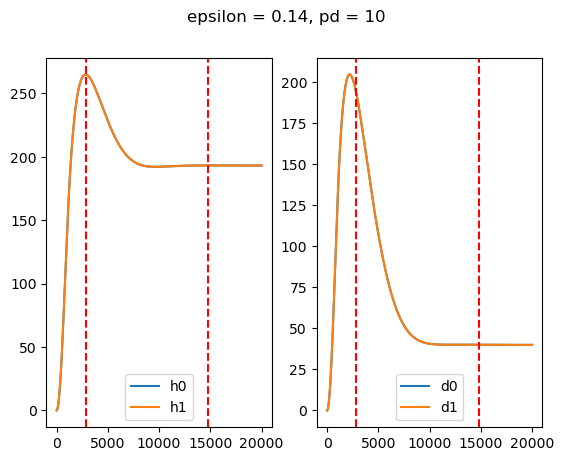

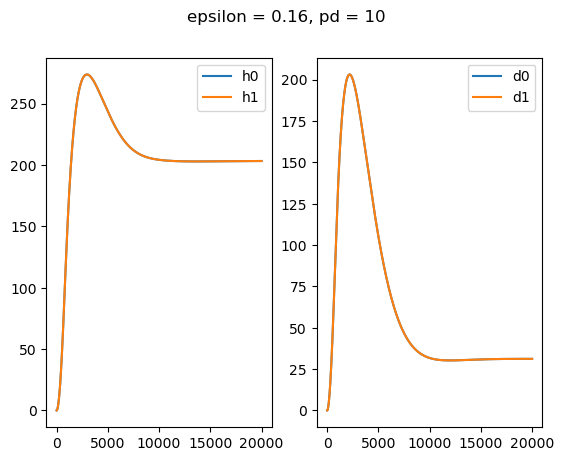

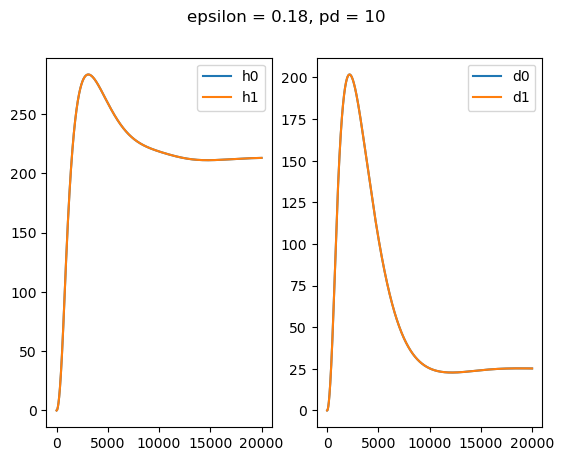

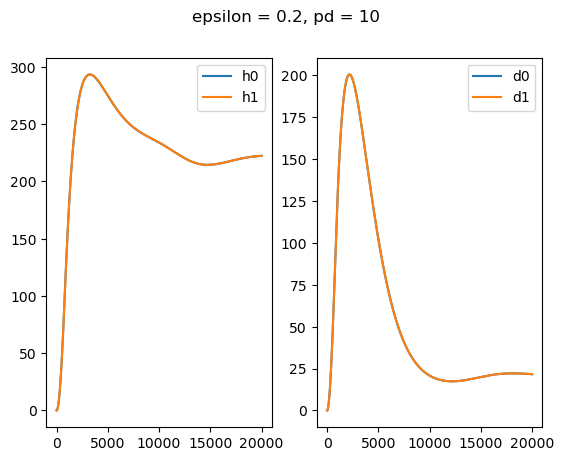

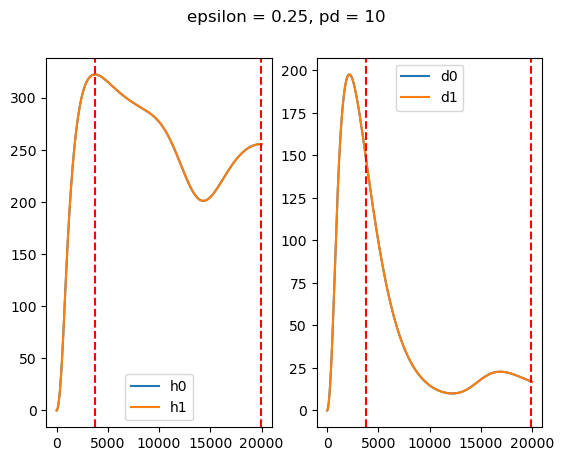

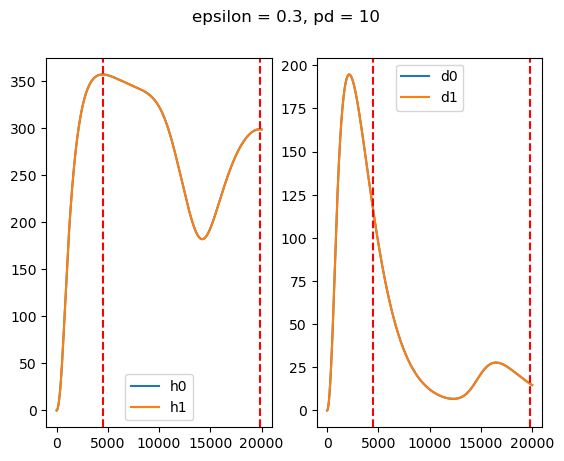

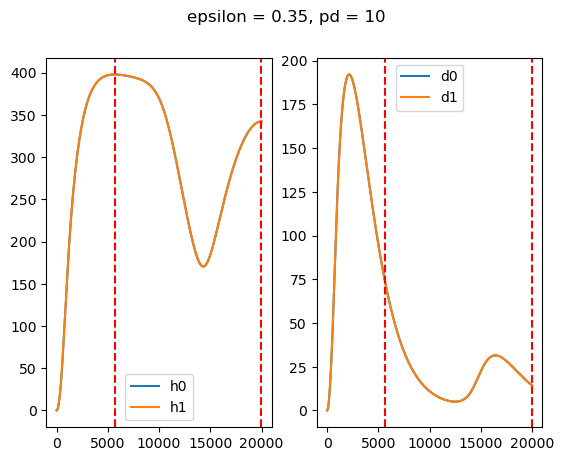

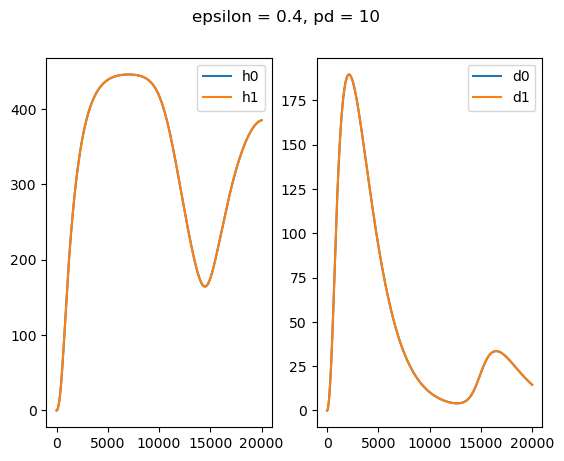

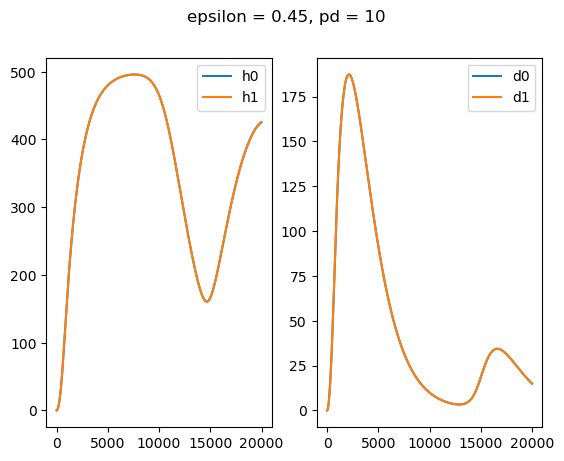

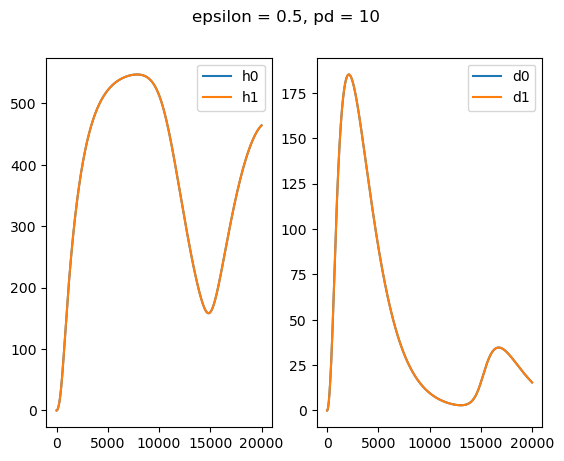

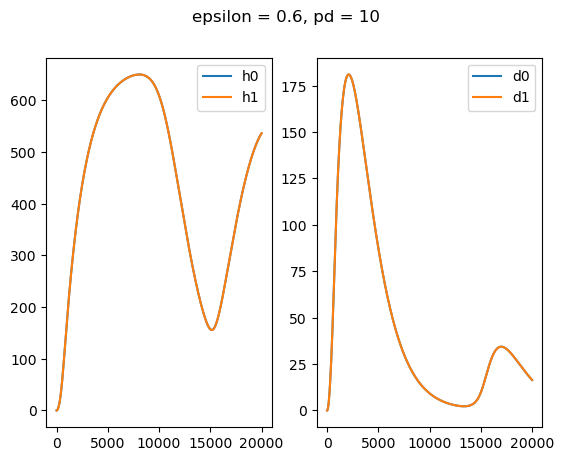

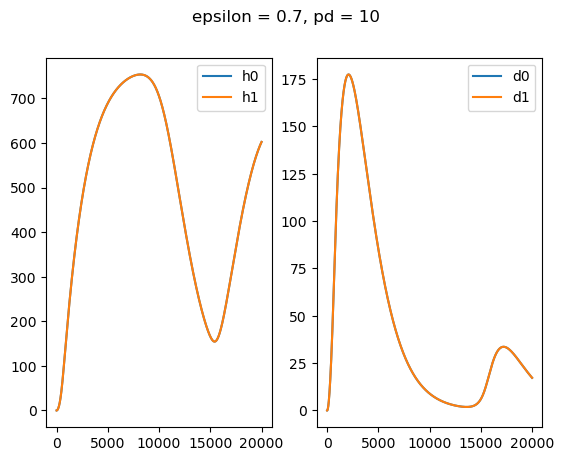

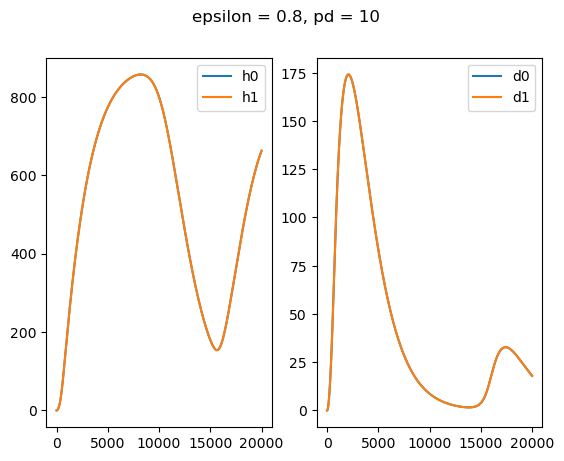

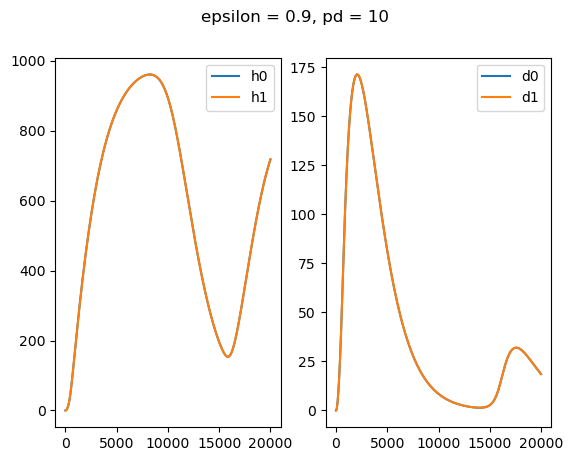

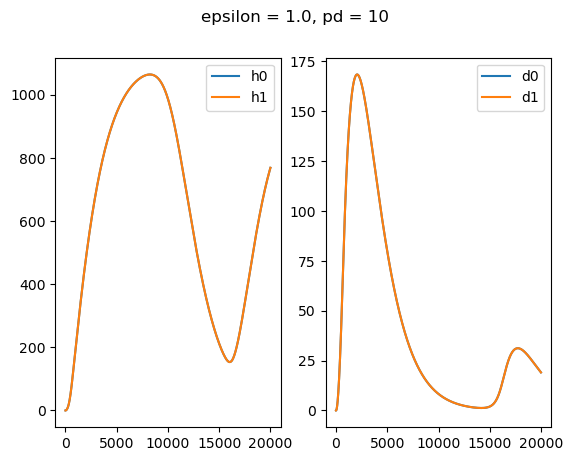

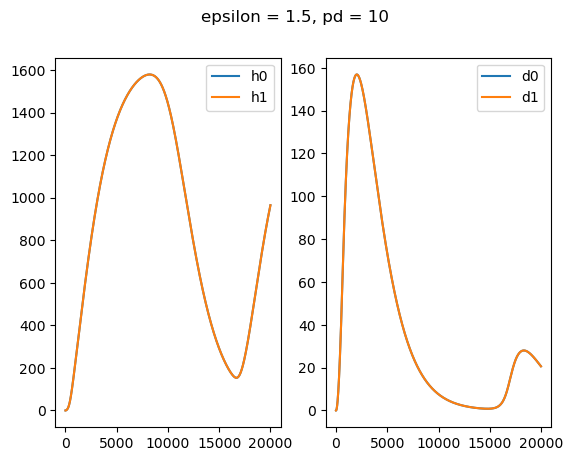

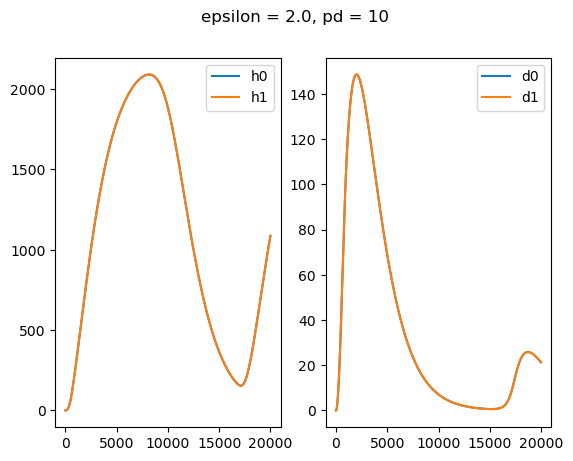

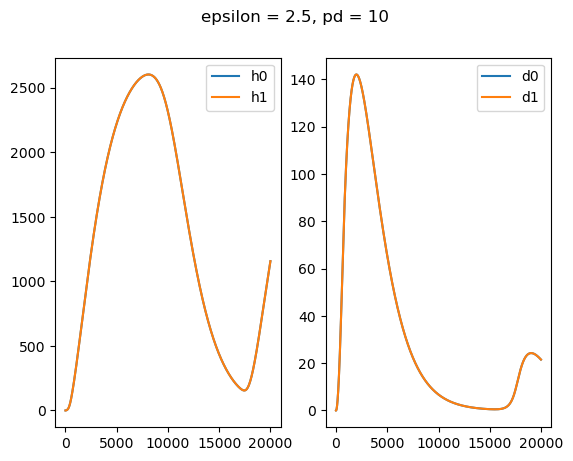

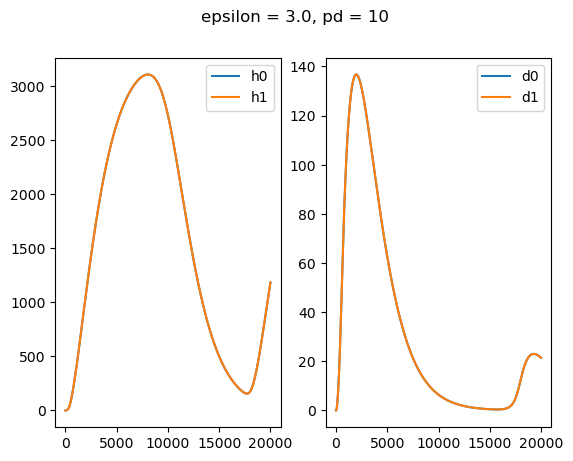

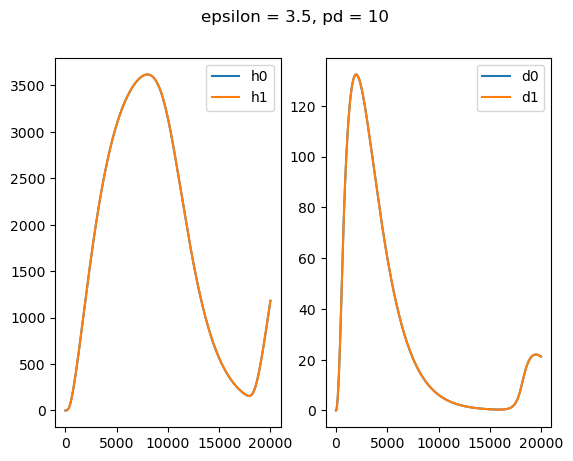

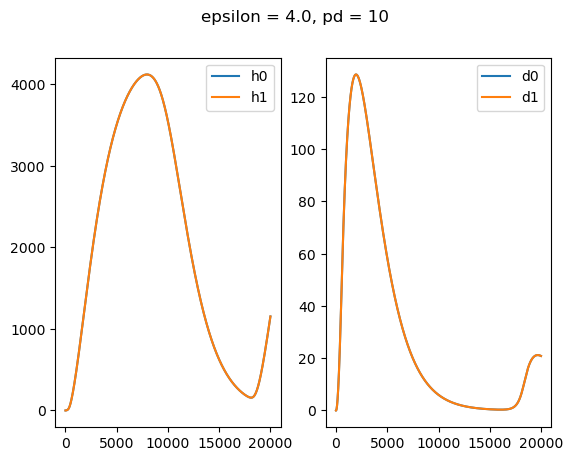

In [26]:

signal = results_pd_uni

i = 0
for j in range(len(epsilons)):
    period, peaks = estimate_period_from_peaks(signal[i,j,:,0,0], time=np.arange(num_tsteps)*dt, distance=5000)
    period_troughs, troughs = estimate_period_from_peaks(-signal[i,j,:,0,0], time=np.arange(num_tsteps)*dt, distance=5000)

    peaks = peaks/dt
    troughs = troughs/dt

    # if j == 0:
    #     print(troughs)
    #     print(np.diff(troughs))

    plt.figure()
    plt.suptitle(f'epsilon = {epsilons[j]}, pd = {p_ds[i]}')
    plt.subplot(1, 2, 1)
    plt.plot(signal[i,j,:,0,0], label='h0')
    plt.plot(signal[i,j,:,0,1], label='h1')
    for k in range(len(peaks)):
        plt.axvline(x=peaks[k], color='r', linestyle='--')
    for k in range(len(troughs)):
        plt.axvline(x=troughs[k], color='b', linestyle='--')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(signal[i,j,:,1,0], label='d0')
    plt.plot(signal[i,j,:,1,1], label='d1')
    for k in range(len(peaks)):
        plt.axvline(x=peaks[k], color='r', linestyle='--')
    for k in range(len(troughs)):
        plt.axvline(x=troughs[k], color='b', linestyle='--')
    plt.legend()
